# Sampling of multivariate random variables

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, optimize
import seaborn as sns
from math import sqrt
from itertools import combinations
sns.set_theme(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')

In [2]:
!git clone https://github.com/ITMO-NSS-team/BAMT.git

Cloning into 'BAMT'...
remote: Enumerating objects: 1456, done.
remote: Counting objects: 100% (899/899), done.
remote: Compressing objects: 100% (647/647), done.
remote: Total 1456 (delta 410), reused 684 (delta 232), pack-reused 557
Receiving objects: 100% (1456/1456), 72.88 MiB | 15.50 MiB/s, done.
Resolving deltas: 100% (590/590), done.


In [2]:
import sys
sys.path.append('/content/BAMT')

In [ ]:
!pip install -r /content/BAMT/requirements.txt

In [ ]:
!pip install statsmodels --upgrade

In [4]:
from visualization.visualization import draw_BN
from bayesian.sampling import generate_synthetics
from sklearn.model_selection import train_test_split
from bayesian.calculate_accuracy import calculate_acc
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import discretization, get_nodes_sign, get_nodes_type
from bayesian.save_bn import save_structure, save_params, read_structure, read_params

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lars, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [6]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
# https://drive.google.com/file/d/1HLg3JNYgewoigLfXsKk6Cs33TBZB4dl-/view?usp=sharing
id = '1HLg3JNYgewoigLfXsKk6Cs33TBZB4dl-' 
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('smart_home.csv')  

In [8]:
smart_home = pd.read_csv('smart_home.csv')
print(smart_home.shape)
smart_home.dropna(inplace=True)
print(smart_home.shape)
smart_home['time'] = smart_home['time'].apply(lambda x: pd.Timestamp(int(x), unit='s'))
smart_home['second'] = smart_home['time'].apply(lambda x: x.second)
smart_home['hour'] = smart_home['time'].apply(lambda x: x.hour)
smart_home = smart_home[smart_home['second'] == 0]
smart_home.drop('second', axis=1, inplace=True)
smart_home.reset_index(inplace=True, drop=True)
print(smart_home.shape)
smart_home.summary = pd.Categorical(smart_home.summary)
smart_home['summary_code'] = smart_home.summary.cat.codes
smart_home['summary_code'] = smart_home['summary_code'].apply(lambda x: x + 1)
smart_home['summary_code'] = smart_home['summary_code'].astype(float)
smart_home.head(5)

(503911, 32)
(503910, 32)
(8399, 33)


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,hour,summary_code
0,2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.40,0.0,5,4.0
1,2016-01-01 05:01:00,0.465133,0.003450,0.465133,0.000017,0.064500,0.062633,0.043250,0.005017,0.123350,0.012950,0.000717,0.000083,0.000017,0.031800,0.001000,0.004233,0.001633,0.003450,35.87,partly-cloudy-night,0.61,10.0,Mostly Cloudy,29.40,1016.25,8.29,0.75,285.0,0.0,23.90,0.0,5,13.0
2,2016-01-01 05:02:00,0.539167,0.003517,0.539167,0.000033,0.100133,0.116283,0.043367,0.007617,0.007083,0.013133,0.000683,0.000050,0.000000,0.031800,0.001017,0.004083,0.001617,0.003517,35.40,clear-night,0.61,10.0,Clear,28.87,1015.98,8.20,0.75,281.0,0.0,23.39,0.0,5,4.0
3,2016-01-01 05:03:00,0.380317,0.003433,0.380317,0.000000,0.070233,0.062700,0.070417,0.005100,0.007167,0.013150,0.000733,0.000033,0.000033,0.031783,0.001017,0.004267,0.001650,0.003433,35.25,clear-night,0.64,10.0,Clear,30.51,1016.07,5.47,0.75,265.0,0.0,24.18,0.0,5,4.0
4,2016-01-01 05:04:00,0.940617,0.003500,0.940617,0.000200,0.430700,0.063417,0.043533,0.122917,0.006983,0.012750,0.000483,0.000217,0.000000,0.031733,0.001000,0.004117,0.001567,0.003500,35.49,clear-night,0.64,10.0,Clear,29.65,1015.86,7.08,0.75,265.0,0.0,24.35,0.0,5,4.0


### Step 1
Choose variables for sampling from your dataset (overall – about 10 variables, 3-4 – target variables, the rest - predictors).


In [9]:
subsample = ['humidity', 'visibility', 'temperature', 'pressure', 'dewPoint', 'precipProbability', 'windBearing']
target = ['windSpeed', 'apparentTemperature', 'use [kW]']
smart_home_subsample = smart_home[subsample + target]
smart_home_target = smart_home[target]

### Step 2. 
Using univariate parametric distributions that were fitted in make sampling of
chosen target variables. Use for this 2 different sampling methods.

In [10]:
def outlier_removal(df, var):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    
    min_dist = q1 - (1.5 * (q3 - q1))
    max_dist = q3 + (1.5 * (q3 - q1))

    df_list = list(df[(df[var] < max_dist) & (df[var] > min_dist)][var].values)
    df = pd.DataFrame(df_list)
    df.rename({0: var}, axis=1, inplace=True)
    return df[var]

In [11]:
def estimation(df, var, ax):  
    df = outlier_removal(df, var)
    x = np.linspace(df.min(), df.max(), len(df))
    kernel = stats.kde.gaussian_kde(df)
    sns.histplot(df, kde=False, stat='density', ax=ax)
    
    ax.plot(x, kernel(x), 'r-')
    ax.set_ylabel("Density")
    ax.set_xlabel(var)

In [12]:
def distribution_plt(df, var, ax, distributions):
    df = outlier_removal(df, var)
    for distribution in distributions:
        x = np.linspace(df.min(), df.max(), len(df))
        sns.lineplot(x, distribution.pdf(x, *distribution.fit(df)), label=type(distribution).__name__, ax=ax)
        axs[var].legend()

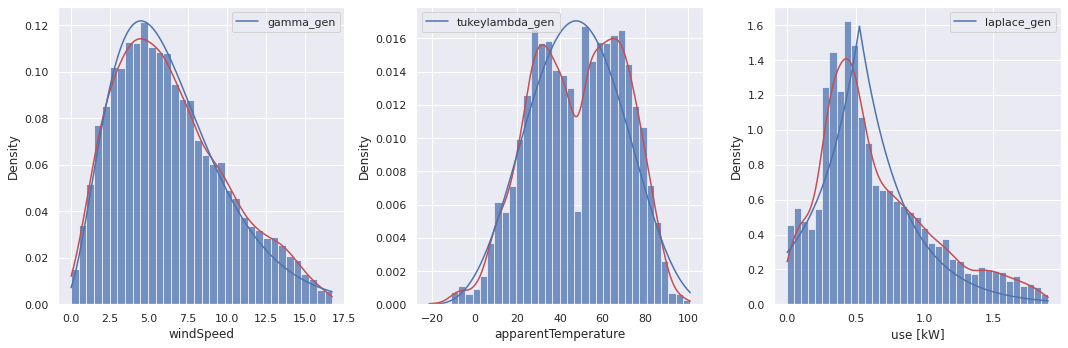

In [13]:
axs = {key: 0 for key in target}
fig, (axs[target[0]], axs[target[1]], axs[target[2]]) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

distributions = {key: 0 for key in target}
distributions['apparentTemperature'] = [stats.tukeylambda]
distributions['windSpeed'] = [stats.gamma]
distributions['use [kW]'] = [stats.laplace]


for var in target:
    estimation(smart_home_target, var, axs[var])
    distribution_plt(smart_home_target, var, axs[var], distributions[var])

fig.tight_layout()

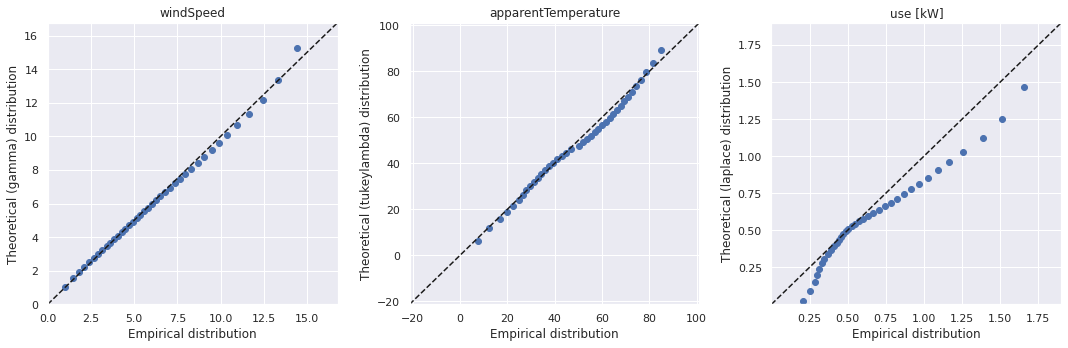

In [14]:
def qq_biplots(df, var, dist_name, ax):
    df = outlier_removal(df, var)
    df_max = df.max()
    df_min = df.min()
    x = np.linspace(df_min, df_max)
    percs = np.linspace(0, 100, 41)
    qn = np.percentile(df, percs)

    qn_dist = dist.ppf(percs / 100.0, *dist.fit(df))
    ax.plot(qn, qn_dist, ls="", marker="o", markersize=6)
    ax.plot(x, x, color="k", ls="--")
    ax.set_xlim(df_min, df_max)
    ax.set_ylim(df_min, df_max)
    ax.set_xlabel('Empirical distribution')
    ax.set_ylabel(f'Theoretical ({dist_name}) distribution')
    ax.set_title(var)


axs = {key: 0 for key in target}
fig, (axs[target[0]], axs[target[1]], axs[target[2]]) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

for var in target:
    for dist in distributions[var]:
        qq_biplots(smart_home_target, var, type(dist).__name__[:-4], axs[var])
        
fig.tight_layout()     

### Inverse transform sampling

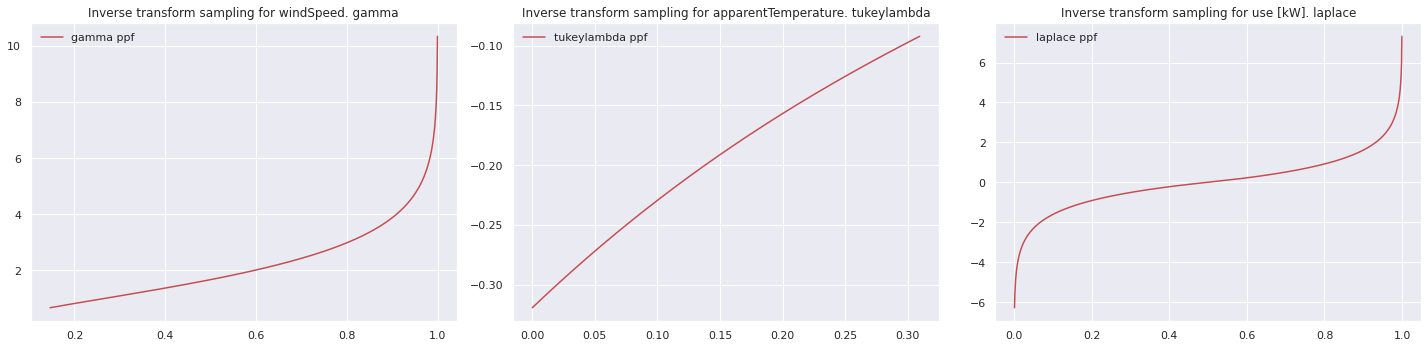

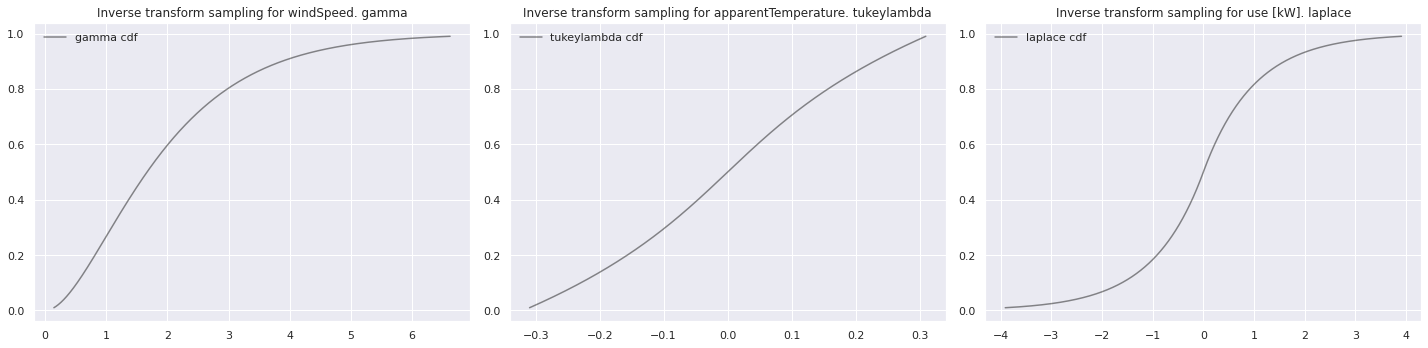

In [34]:
def inverse_ts_distributions(df, var, dist, ax, f="cdf"):
    
    if type(dist).__name__[:-4] == "laplace":
        x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), len(df))
        if f == "ppf":
            ax.plot(x, dist.ppf(x), 'r-', label='laplace ppf')
        else:
            ax.plot(x, dist.cdf(x), 'k-', label='laplace cdf', alpha=0.5)
        ax.legend(loc='best', frameon=False)
    elif type(dist).__name__[:-4] == "tukeylambda":
        lam = 3.13
        x = np.linspace(dist.ppf(0.01, lam), dist.ppf(0.99, lam), len(df))
        if f == "ppf":
            ax.plot(x, dist.ppf(x, lam), 'r-', label='tukeylambda ppf')
        else:
            ax.plot(x, dist.cdf(x, lam), 'k-', label='tukeylambda cdf', alpha=0.5)
        ax.legend(loc='best', frameon=False)
    elif type(dist).__name__[:-4] == "gamma":
        a = 1.99
        x = np.linspace(dist.ppf(0.01, a), dist.ppf(0.99, a), len(df))
        if f == "ppf":
            ax.plot(x, dist.ppf(x, a), 'r-', label='gamma ppf')
        else:
            ax.plot(x, dist.cdf(x, a), 'k-', label='gamma cdf', alpha=0.5)
        ax.legend(loc='best', frameon=False)

    ax.set_title(f'Inverse transform sampling for {var}. {type(dist).__name__[:-4]}')

for f in ["ppf", "cdf"]:
    axs = {key: 0 for key in target}
    fig, (axs[target[0]], axs[target[1]], axs[target[2]]) = plt.subplots(1, 3)
    fig.set_size_inches(20, 5)

    for var in target:
        for dist in distributions[var]:
            inverse_ts_distributions(smart_home_target, var, dist, axs[var], f=f)
    fig.tight_layout()     

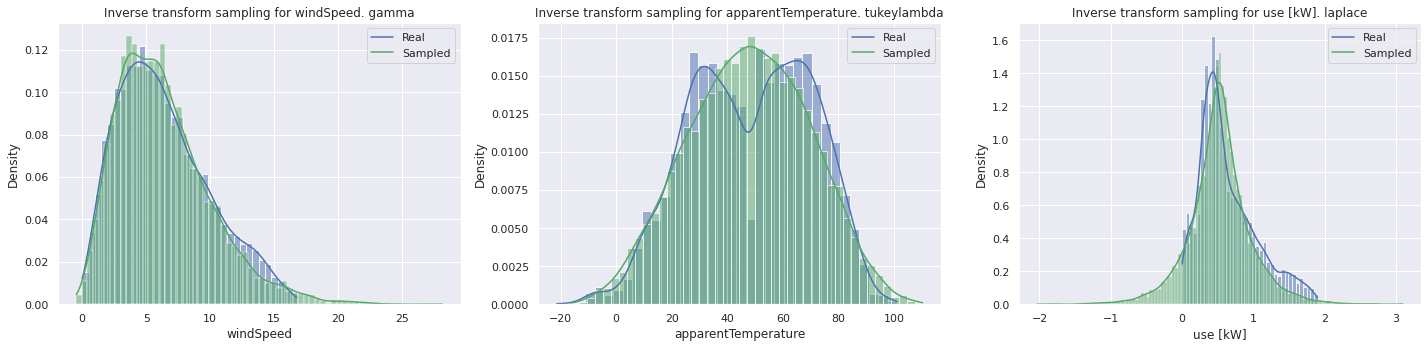

In [15]:
def inverse_transform_sampling(n, dist, param):
    gen = np.random.uniform(size=n)
    rv = dist(*param)
    return rv.ppf(gen)

def inverse_transform_sampling_plot(df, var, dist, ax):
    df = outlier_removal(df, var)

    params = dist.fit(df)
    its = inverse_transform_sampling(10000, dist, params)

    sns.histplot(df, kde=True, stat='density', label='initial data', ax=ax)
    sns.histplot(its, kde=True, stat='density', label='sampled data', ax=ax, color="g")

    ax.set_ylabel('Density')
    ax.set_title(f'Inverse transform sampling for {var}. {type(dist).__name__[:-4]}')
    ax.legend(['Real', 'Sampled'])


axs = {key: 0 for key in target}
fig, (axs[target[0]], axs[target[1]], axs[target[2]]) = plt.subplots(1, 3)
fig.set_size_inches(20, 5)

for var in target:
    for dist in distributions[var]:
        inverse_transform_sampling_plot(smart_home_target, var, dist, axs[var])
fig.tight_layout()     

### Accept-reject sampling

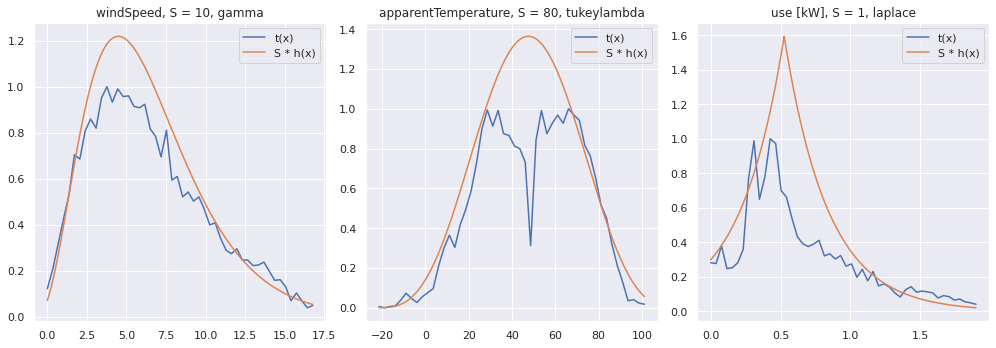

In [103]:
def accept_reject_sampling_hx(data, distributions, axs):
    dict_S = {
        "windSpeed": 10,
        "apparentTemperature": 80,
        "use [kW]": 1
    }
    for i, col in enumerate(data.columns):
        df = outlier_removal(data, col)
        x = np.linspace(df.min(), df.max(), len(df))
        bins_n = 50
        hist_y_1, hist_x_1 = np.histogram(np.array(df), bins =bins_n, density=True)
        x_1 = np.linspace(hist_x_1[0], hist_x_1[bins_n], bins_n)

        axs[col].plot(x_1, hist_y_1/np.max(hist_y_1), label = "t(x)")
        dist = distributions[col][0]
        params = dist.fit(df)
        S = dict_S[col] 
        axs[col].plot(x, S * dist.pdf(x, *params), label = "S * h(x)")
        axs[col].set_title(f"{col}, S = {S}, {type(dist).__name__[:-4]}")
        axs[col].legend()

axs = {key: 0 for key in target}
fig, (axs[target[0]], axs[target[1]], axs[target[2]]) = plt.subplots(1, 3)
fig.set_size_inches(14, 5)
accept_reject_sampling_hx(smart_home_target, distributions, axs)
fig.tight_layout()    

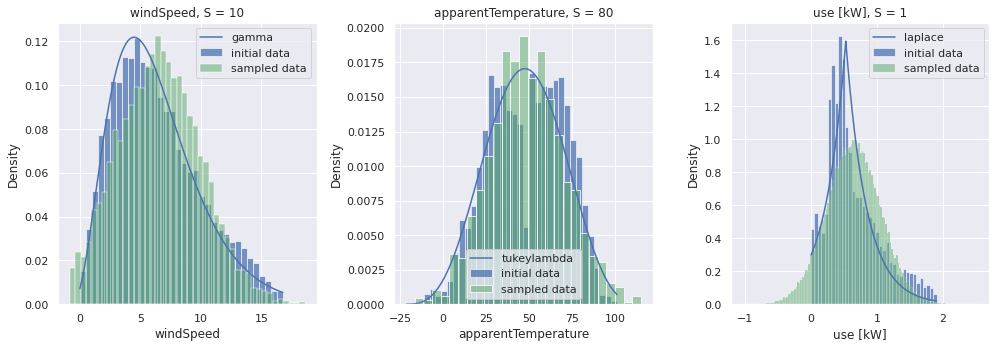

In [105]:
def accept_reject_sampling(data, distributions, axs):
    dict_S = {
        "windSpeed": 10,
        "apparentTemperature": 80,
        "use [kW]": 1
    }
    for i, col in enumerate(data.columns):
        df = outlier_removal(data, col)
        x = np.linspace(df.min(), df.max(), len(df))

        sns.histplot(df, stat='density', label='initial data', ax=axs[col])
        dist = distributions[col][0]
        params = dist.fit(df)
        vals = dist.pdf(x,*params)
        axs[col].plot(x, vals, label=type(dist).__name__[:-4])
        N = 100000
        S = dict_S[col] 
        candidates = np.random.normal(df.mean(), df.std(), size=(N,))
        prob_accept = dist.pdf(candidates, *params) / (S * dist.pdf(candidates, *params))
        mask = np.random.random(size=(N,)) < prob_accept
        sns.histplot(candidates[mask], stat='density', label='sampled data', alpha=0.5, color='g',ax=axs[col])
        axs[col].set_title(f"{col}, S = {S}")
        axs[col].legend()

axs = {key: 0 for key in target}
fig, (axs[target[0]], axs[target[1]], axs[target[2]]) = plt.subplots(1, 3)
fig.set_size_inches(14, 5)

accept_reject_sampling(smart_home_target, distributions, axs)
fig.tight_layout()    

### Step 3
Estimate relations between predictors and chosen target variables. At least, they should have significant correlation coefficients.

In [32]:
smart_home_train, smart_home_test = train_test_split(smart_home_subsample, test_size=0.3, shuffle=True)

In [33]:
corr = smart_home_train.corr()
corr

,humidity,visibility,temperature,pressure,dewPoint,precipProbability,windBearing,windSpeed,apparentTemperature,use [kW]
humidity,1.000000,-0.502852,-0.093822,-0.136150,0.361593,0.326877,-0.215514,-0.444254,-0.049448,0.024309
visibility,-0.502852,1.000000,0.112281,0.165912,-0.090924,-0.497714,0.161765,0.174368,0.094657,-0.018507
temperature,-0.093822,0.112281,1.000000,-0.187090,0.889680,0.045412,-0.053987,-0.064653,0.993137,-0.007897
pressure,-0.136150,0.165912,-0.187090,1.000000,-0.240180,-0.241995,-0.157434,-0.244392,-0.166566,0.012803
dewPoint,0.361593,-0.090924,0.889680,-0.240180,1.000000,0.177447,-0.141728,-0.243758,0.901027,0.004147
precipProbability,0.326877,-0.497714,0.045412,-0.241995,0.177447,1.000000,-0.130720,-0.032127,0.051496,-0.000701
windBearing,-0.215514,0.161765,-0.053987,-0.157434,-0.141728,-0.130720,1.000000,0.214307,-0.076800,-0.004252
windSpeed,-0.444254,0.174368,-0.064653,-0.244392,-0.243758,-0.032127,0.214307,1.000000,-0.136479,-0.015865
apparentTemperature,-0.049448,0.094657,0.993137,-0.166566,0.901027,0.051496,-0.076800,-0.136479,1.000000,-0.012012
use [kW],0.024309,-0.018507,-0.007897,0.012803,0.004147,-0.000701,-0.004252,-0.015865,-0.012012,1.000000


Text(0.5, 1.0, 'Correlation Plot')

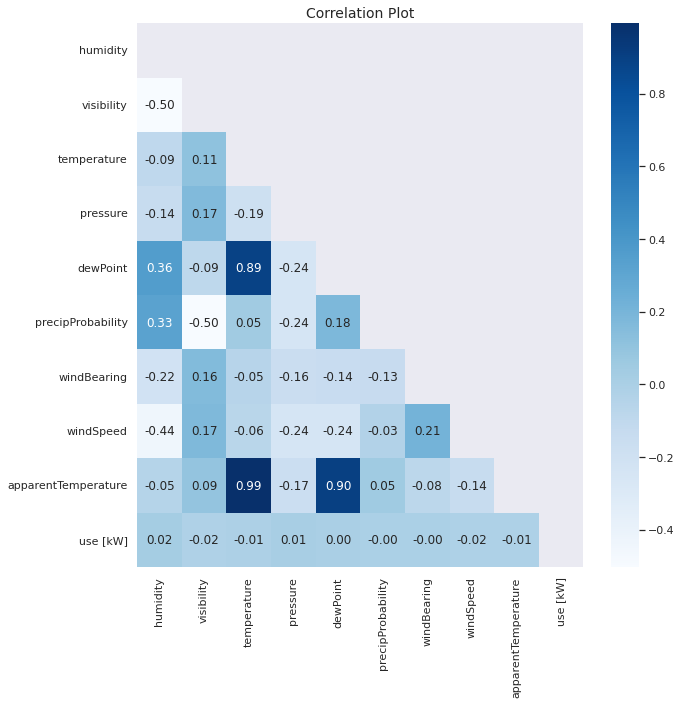

In [34]:
corr = smart_home_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, mask = mask, annot=True, fmt= '.2f', ax = ax, cmap = 'Blues')
ax.set_title('Correlation Plot', fontsize=14)

In [35]:
corr[(corr < 0.01)] = ''
corr

,humidity,visibility,temperature,pressure,dewPoint,precipProbability,windBearing,windSpeed,apparentTemperature,use [kW]
humidity,1.0,,,,0.361593,0.326877,,,,0.024309
visibility,,1.0,0.112281,0.165912,,,0.161765,0.174368,0.094657,
temperature,,0.112281,1.0,,0.88968,0.045412,,,0.993137,
pressure,,0.165912,,1.0,,,,,,0.012803
dewPoint,0.361593,,0.88968,,1.0,0.177447,,,0.901027,
precipProbability,0.326877,,0.045412,,0.177447,1.0,,,0.051496,
windBearing,,0.161765,,,,,1.0,0.214307,,
windSpeed,,0.174368,,,,,0.214307,1.0,,
apparentTemperature,,0.094657,0.993137,,0.901027,0.051496,,,1.0,
use [kW],0.024309,,,0.012803,,,,,,1.0


### Step 4
Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm.

In [36]:
nodes_type = get_nodes_type(smart_home_subsample)
nodes_type

{'humidity': 'cont',
 'visibility': 'cont',
 'temperature': 'cont',
 'pressure': 'cont',
 'dewPoint': 'cont',
 'precipProbability': 'cont',
 'windBearing': 'cont',
 'windSpeed': 'cont',
 'apparentTemperature': 'cont',
 'use [kW]': 'cont'}

In [37]:
nodes_sign = get_nodes_sign(smart_home_subsample)
nodes_sign

{'humidity': 'pos',
 'visibility': 'pos',
 'temperature': 'neg',
 'pressure': 'pos',
 'dewPoint': 'neg',
 'precipProbability': 'pos',
 'windBearing': 'pos',
 'windSpeed': 'pos',
 'apparentTemperature': 'neg',
 'use [kW]': 'pos'}

In [42]:
discrete_data, coder = discretization(smart_home_train, 'equal_frequency', list(nodes_sign.keys()))
discrete_data

,humidity,visibility,temperature,pressure,dewPoint,precipProbability,windBearing,windSpeed,apparentTemperature,use [kW]
0,4,0,1,2,2,0,0,1,1,0
1,1,2,1,4,1,0,1,0,2,2
2,1,2,3,4,3,0,1,1,3,3
3,1,2,1,3,0,0,2,1,1,0
4,4,0,0,3,1,0,4,3,0,1
...,...,...,...,...,...,...,...,...,...,...
5874,3,2,4,4,4,0,1,2,4,0
5875,1,2,4,2,4,0,2,4,4,4
5876,1,1,2,0,1,0,3,4,1,2
5877,3,2,1,4,1,0,1,2,1,2


In [39]:
bayes_net = {'V': smart_home_subsample.columns.to_list(),
      'E': [['humidity', 'dewPoint'],
            ['humidity', 'precipProbability'],
            ['humidity', 'use [kW]'],
            ['visibility', 'temperature'],
            ['visibility', 'pressure'],
            ['visibility', 'windBearing'],
            ['visibility', 'windSpeed'],
            ['visibility', 'apparentTemperature'],
            ['temperature', 'dewPoint'],
            ['temperature', 'precipProbability'],
            ['temperature', 'apparentTemperature'],
            ['pressure', 'use [kW]'],
            ['dewPoint', 'precipProbability'],
            ['dewPoint', 'apparentTemperature'],
            ['precipProbability', 'apparentTemperature'],
            ['windBearing', 'windSpeed']]}

In [ ]:
draw_BN(bayes_net, nodes_type, 'eslipse_bn_corr_an')

In [41]:
params = parameter_learning(smart_home_train, nodes_type, bayes_net, 'simple')
save_structure(bayes_net, 'bayes_structure_correlation')
skel = read_structure('bayes_structure_correlation')
save_params(params, 'bayes_params_correlation')
params = read_params('bayes_params_correlation')
bayes_correlation = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(bayes_correlation, nodes_sign, 'simple', 1000)

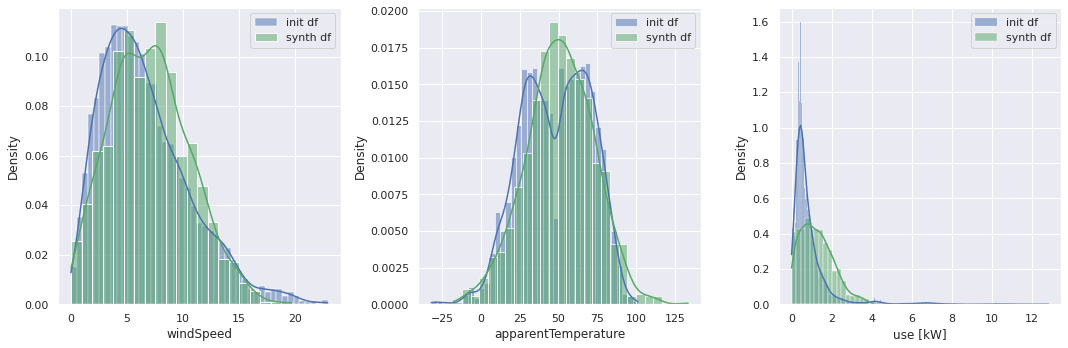

In [43]:
axs = {key: 0 for key in target}
fig, (axs[target[0]], axs[target[1]], axs[target[2]]) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
        
    
for var in target:
    sns.histplot(smart_home_subsample[var], ax=axs[var], stat='density', label='init df', kde=True)
    sns.histplot(synth_df[var], ax=axs[var], stat='density', color='g', label='synth df', kde=True)
    axs[var].legend()

fig.tight_layout() 

In [ ]:
accuracy = calculate_acc(bayes_correlation, smart_home_test, target, 'simple')

In [48]:
print(accuracy[0])
accuracy[1]

{}


{'windSpeed': 3.808, 'apparentTemperature': 2.328, 'use [kW]': 1.122}

### Step 5 & 6
Build a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning.

In [50]:
bayes_net = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
bayes_net

{'V': ['humidity',
  'visibility',
  'temperature',
  'pressure',
  'dewPoint',
  'precipProbability',
  'windBearing',
  'windSpeed',
  'apparentTemperature',
  'use [kW]'],
 'E': [['humidity', 'windSpeed'],
  ['humidity', 'visibility'],
  ['visibility', 'pressure'],
  ['visibility', 'windBearing'],
  ['visibility', 'windSpeed'],
  ['temperature', 'apparentTemperature'],
  ['temperature', 'dewPoint'],
  ['temperature', 'windBearing'],
  ['temperature', 'pressure'],
  ['temperature', 'humidity'],
  ['pressure', 'windBearing'],
  ['dewPoint', 'pressure'],
  ['dewPoint', 'windBearing'],
  ['dewPoint', 'windSpeed'],
  ['dewPoint', 'humidity'],
  ['windSpeed', 'windBearing'],
  ['windSpeed', 'pressure'],
  ['apparentTemperature', 'dewPoint'],
  ['apparentTemperature', 'humidity'],
  ['apparentTemperature', 'use [kW]'],
  ['apparentTemperature', 'visibility']]}

In [ ]:
draw_BN(bayes_net, nodes_type, 'eslipse_bn_hc_k2')

In [52]:
params = parameter_learning(smart_home_train, nodes_type, bayes_net, 'simple')
save_structure(bayes_net, 'bayes_structure_hc_k2')
skel = read_structure('bayes_structure_hc_k2')
save_params(params, 'bayes_params_hc_k2')
params = read_params('bayes_params_hc_k2')
bayes_hc_k2 = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(bayes_hc_k2, nodes_sign, 'simple', 1000)

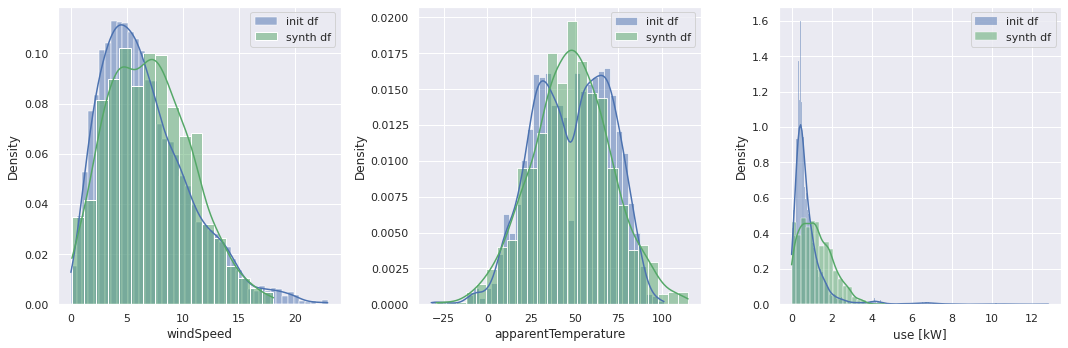

In [53]:
axs = {key: 0 for key in target}
fig, (axs[target[0]], axs[target[1]], axs[target[2]]) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
        
    
for var in target:
    sns.histplot(smart_home_subsample[var], ax=axs[var], stat='density', label='init df', kde=True)
    sns.histplot(synth_df[var], ax=axs[var], stat='density', color='g', label='synth df', kde=True)
    axs[var].legend()

fig.tight_layout() 

In [ ]:
accuracy = calculate_acc(bayes_hc_k2, smart_home_test, target, 'simple')

In [57]:
accuracy[1]

{'windSpeed': 3.548, 'apparentTemperature': 2.468, 'use [kW]': 1.122}

Evoluation algorithm + MI

In [58]:
bayes_net = structure_learning(discrete_data, 'evo', nodes_type, 'MI')

Best metric is 7.5054
Generation num: 0
max_depth: 6, no improvements: 0
spent time: 0.2 min
Best metric is 7.5054
Generation num: 1
max_depth: 6, no improvements: 1
spent time: 0.4 min
Best metric is 7.4799
Generation num: 2
max_depth: 6, no improvements: 0
spent time: 0.5 min
Best metric is 7.4626
Generation num: 3
max_depth: 6, no improvements: 0
spent time: 0.7 min
Best metric is 7.4626
Generation num: 4
max_depth: 6, no improvements: 1
spent time: 0.8 min
Best metric is 7.4626
Generation num: 5
max_depth: 6, no improvements: 2
spent time: 1.0 min
Best metric is 7.4626
Generation num: 6
max_depth: 6, no improvements: 3
spent time: 1.1 min
Best metric is 7.4441
Generation num: 7
max_depth: 6, no improvements: 0
spent time: 1.3 min
Best metric is 7.4441
Generation num: 8
max_depth: 6, no improvements: 1
spent time: 1.5 min
Best metric is 7.4441
Generation num: 9
max_depth: 6, no improvements: 2
spent time: 1.6 min
Best metric is 7.4174
Generation num: 10
max_depth: 6, no improvements

In [59]:
bayes_net

{'V': ['humidity',
  'visibility',
  'temperature',
  'pressure',
  'dewPoint',
  'precipProbability',
  'windBearing',
  'windSpeed',
  'apparentTemperature',
  'use [kW]'],
 'E': [['precipProbability', 'pressure'],
  ['precipProbability', 'windSpeed'],
  ['visibility', 'precipProbability'],
  ['visibility', 'pressure'],
  ['visibility', 'windSpeed'],
  ['visibility', 'temperature'],
  ['use [kW]', 'precipProbability'],
  ['use [kW]', 'pressure'],
  ['windSpeed', 'dewPoint'],
  ['temperature', 'windSpeed'],
  ['apparentTemperature', 'dewPoint'],
  ['apparentTemperature', 'temperature']]}

In [ ]:
draw_BN(bayes_net, nodes_type, 'eslipse_bn_evo_mi')

In [60]:
params = parameter_learning(smart_home_train, nodes_type, bayes_net, 'simple')
save_structure(bayes_net, 'bayes_structure_evo_mi')
skel = read_structure('bayes_structure_evo_mi')
save_params(params, 'bayes_params_evo_mi')
params = read_params('bayes_params_evo_mi')
bayes_evo_mi = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(bayes_evo_mi, nodes_sign, 'simple', 1000)

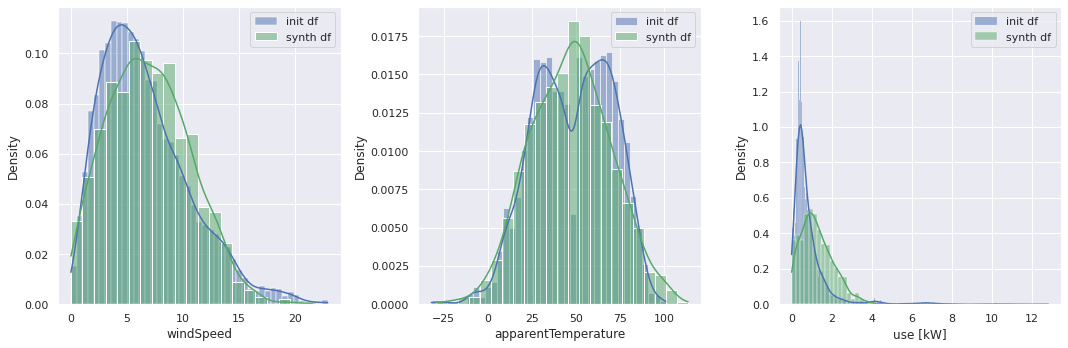

In [61]:
axs = {key: 0 for key in target}
fig, (axs[target[0]], axs[target[1]], axs[target[2]]) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
        
    
for var in target:
    sns.histplot(smart_home_subsample[var], ax=axs[var], stat='density', label='init df', kde=True)
    sns.histplot(synth_df[var], ax=axs[var], stat='density', color='g', label='synth df', kde=True)
    axs[var].legend()

fig.tight_layout() 

In [ ]:
accuracy = calculate_acc(bayes_evo_mi, smart_home_test, target, 'simple')

In [63]:
accuracy[1]

{'windSpeed': 3.882, 'apparentTemperature': 21.612, 'use [kW]': 1.122}